In [205]:
import pandas as pd
import string
import numpy as np
import re

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from tqdm import tqdm

import matplotlib.pyplot as plt

from collections import defaultdict

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

In [2]:
df = pd.read_csv('../All_irregular_verb_list.csv', sep=';', encoding='utf-8')
df = df[['First', 'Second', 'Third']]

In [3]:
for column in df.columns[1:]:
    df[column] = df[column].apply(lambda x: re.sub(r'[/.*]', '', x))
    df[column] = df[column].apply(lambda x: re.sub(r'[^a-zA-Z]', '', x))

criteria = df['First'].map(lambda x: len(set(x) & set(string.ascii_uppercase)) == 0)
df = df[criteria]
df = df.reset_index(drop=True)

In [4]:
df[:3]

,First,Second,Third
0,abide,abode,abode
1,arise,arose,arisen
2,awake,awoke,awaked


In [5]:
char_emb = {char: i+1 for i, char in enumerate(string.ascii_lowercase)}
char_emb['0'] = 0

In [54]:
decoder = {val: key for key, val in char_emb.items()}

def decode(idx, decoder):
    t = ''.join([decoder[ix] for ix in idx])
    return re.sub(r'[0.*]', '', t)

In [7]:
max_len = 0
for column_id in range(len(df.columns)):
    for i in range(df.index.size-1):
        if len(df[df.columns[column_id]][i]) > max_len:
            max_len = len(df[df.columns[column_id]][i])

In [8]:
def word2emb(emb, n, word):
    res = np.zeros(n, dtype=int)
    for i, char in enumerate(word):
        res[i] = emb[char]
    return res

for column in df.columns:
    print(column)
    df[column] = df[column].apply(lambda word: word2emb(char_emb, max_len, word))

First
Second
Third


In [9]:
# data, labels = df['First'], df.apply(lambda x: np.hstack((x['Second'], x['Third'])), axis=1)
# data, labels = data.map(lambda x: torch.from_numpy(x)), labels.map(lambda x: torch.from_numpy(x))

data, labels = df['First'], df['Second']
data, labels = data.map(lambda x: torch.from_numpy(x)), labels.map(lambda x: torch.from_numpy(x))

In [55]:
def acc(write_res = False):
    accuracy = []
    for sentence, target in zip(data, labels):
        with torch.no_grad():
            tag_scores = model(sentence)
            _, preds = torch.max(tag_scores, 1)
            first = decode(sentence.tolist(), decoder)
            gt = decode(target.tolist(), decoder)
            pred = decode(preds.tolist(), decoder)
            accuracy.append(int(gt == pred))
            if write_res:
                print('{0} => gt: {1}, pred: {2}'.format(first, 
                                                         gt, 
                                                         pred))
    return sum(accuracy) / len(accuracy)

In [11]:
EMBEDDING_DIM = 8
HIDDEN_DIM = 8

In [25]:
class LSTMVerbFormer(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size):
        super(LSTMVerbFormer, self).__init__()
        self.hidden_dim = hidden_dim

        self.char_embeddings = nn.Embedding(vocab_size, embedding_dim)

        self.lstm = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True) # False

        self.hidden2tag = nn.Linear(hidden_dim * 2, vocab_size) # without * 2

    def forward(self, sentence):
        embeds = self.char_embeddings(sentence)
        lstm_out, _ = self.lstm(embeds.view(len(sentence), 1, -1))
        tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores

In [26]:
model = LSTMVerbFormer(EMBEDDING_DIM, HIDDEN_DIM, len(char_emb))
loss_function = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

In [29]:
avg_loss = []
accuracy = []

for epoch in tqdm(range(400)): 
    
    running_loss = []
    for sentence, targets in zip(data, labels):
        model.zero_grad()

        tag_scores = model(sentence)

        loss = loss_function(tag_scores, targets)
        loss.backward()
        optimizer.step()
        
        running_loss.append(loss.item())
    avg_loss.append(round(sum(running_loss) / len(running_loss), 4))
    accuracy.append(round(acc(), 4))

100%|██████████| 400/400 [11:30<00:00,  1.73s/it]


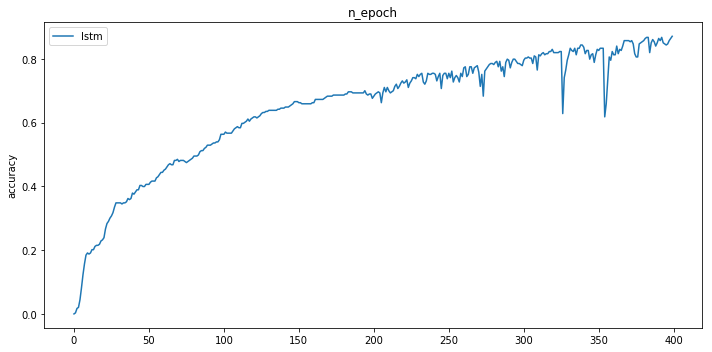

In [30]:
X, Y = range(len(accuracy)), accuracy

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(X, Y, label='lstm')
ax.set_title('n_epoch')
ax.legend(loc='upper left')
ax.set_ylabel('accuracy')
fig.tight_layout()
 
plt.show()

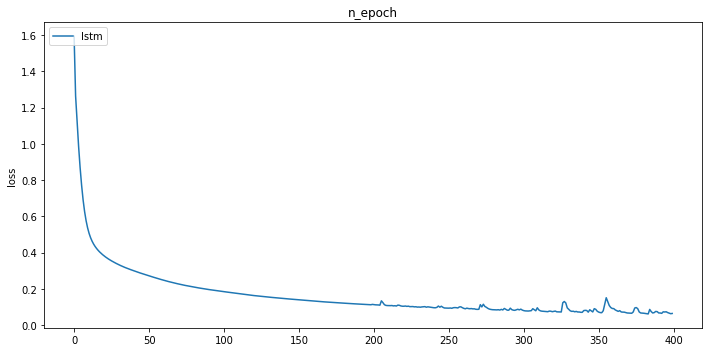

In [31]:
X, Y = range(len(avg_loss)), avg_loss

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(X, Y, label='lstm')
ax.set_title('n_epoch')
ax.legend(loc='upper left')
ax.set_ylabel('loss')
fig.tight_layout()
 
plt.show()

In [32]:
print('{0}%'.format(int(round(acc() * 100, 0))))

87%


In [33]:
fig.savefig('test.png')

In [34]:
with open('test.txt', 'w') as f:
    for sentence, target in zip(data, labels):
        with torch.no_grad():
            tag_scores = model(sentence)
            _, preds = torch.max(tag_scores, 1)
            f.write('{0} => gt: {1}, pred: {2}'.format(re.sub(r'[0.*]', '', decode(sentence.tolist(), decoder)), 
                                                     re.sub(r'[0.*]', '', decode(target.tolist(), decoder)), 
                                                     re.sub(r'[0.*]', '', decode(preds.tolist(), decoder))) + '\n')

In [56]:
acc(True)

abide => gt: abode, pred: abode
arise => gt: arose, pred: arose
awake => gt: awoke, pred: awoke
backbite => gt: backbitten, pred: backbitee
backslide => gt: backslid, pred: backslid
be => gt: was, pred: we
bear => gt: bore, pred: bore
beat => gt: beat, pred: bete
become => gt: became, pred: became
befall => gt: befell, pred: befell
beget => gt: begot, pred: begot
begin => gt: began, pred: began
begird => gt: begirt, pred: begird
behold => gt: beheld, pred: beheld
bend => gt: bent, pred: bent
bereave => gt: bereft, pred: bereav
beseech => gt: besought, pred: besought
beset => gt: beset, pred: beset
bespeak => gt: bespoke, pred: bespoke
bespit => gt: bespat, pred: bespat
bestride => gt: bestrode, pred: bestrode
bet => gt: bet, pred: bet
betake => gt: betook, pred: betook
bid => gt: bad, pred: bad
bind => gt: bound, pred: bound
bite => gt: bit, pred: bit
bleed => gt: bled, pred: bled
bless => gt: blessed, pred: blessed
blow => gt: blew, pred: blew
break => gt: broke, pred: broke
breed => 

0.8703071672354948

In [144]:
embedding_by_last = {}

for sent in tqdm(data):
    with torch.no_grad():
        t = model.char_embeddings(sent)
        t, _ = model.lstm(t.view(len(sent), 1, -1))
        t = t.view(len(sent), -1)
    
        tag_scores = model(sent)
        _, preds = torch.max(tag_scores, 1)
    pred = decode(preds.tolist(), decoder)
    embedding_by_last[pred] = t[-1].numpy()

100%|██████████| 293/293 [00:00<00:00, 428.33it/s]


In [145]:
embedding_by_first = {}

for sent in tqdm(data):
    with torch.no_grad():
        t = model.char_embeddings(sent)
        t, _ = model.lstm(t.view(len(sent), 1, -1))
        t = t.view(len(sent), -1)
    
        tag_scores = model(sent)
        _, preds = torch.max(tag_scores, 1)
    pred = decode(preds.tolist(), decoder)
    embedding_by_first[pred] = t[0].numpy()

100%|██████████| 293/293 [00:00<00:00, 436.97it/s]


In [171]:
embedding_by_avg = {}

for sent in tqdm(data):
    with torch.no_grad():
        t = model.char_embeddings(sent)
        t, _ = model.lstm(t.view(len(sent), 1, -1))
        t = t.view(len(sent), -1)
    
        tag_scores = model(sent)
        _, preds = torch.max(tag_scores, 1)
    pred = decode(preds.tolist(), decoder)
    embedding_by_avg[pred] = (sum(t) / t.shape[0]).numpy()

100%|██████████| 293/293 [00:00<00:00, 415.33it/s]


In [172]:
keys = list(embedding_by_avg.keys())
vectors = []
for emb in (embedding_by_last, embedding_by_first, embedding_by_avg):
    vectors.append([emb[key] for key in keys])

In [174]:
n = 25
kmeans = KMeans(n_clusters=n)

In [175]:
kmeans.fit(vectors[2])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=25, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [176]:
res = defaultdict(list)
for label, key in zip(kmeans.labels_, keys):
    res[label].append(key)

In [177]:
for cluster, val in res.items():
    print('cluster: {0}\n'.format(cluster))
    for el in val:
        print(el)
    print('\n', '='*50, '\n')

cluster: 0

rebound
unbent
drank
unwound
strung
shrank
wrung
stuck
ground
struck
sprang
began


cluster: 1

overdid
overete
gainsaid
overlaid
overbid
underpaid
waylaid
overpaid


cluster: 2

litt
redid
took
came
chid
dived
duryt
rode
made
bete
wound
rove
undid
hav
gave
hid


cluster: 3

bled
spent
sent
knew
rent
leant
bent
bound
bred
woke
lent
found
meant
laded


cluster: 4

girdd
spoilt
dealt
swell
hewed
crowed
showed
heard
mowed


cluster: 5

reheard
shere
spoke
broke
forsook
misheard


cluster: 6

misunderstood
underwrote
interwove
countersank
understood
overdrew
overrode
overthrew


cluster: 7

backslid
broadcast
backbitee
browbeae


cluster: 8

beset
resat
slit
split
sped
reset
hurt
kept
input
slew
inlaid
leapt
spat
swept
upset
bust
crept
burst
bit
inset
unsaid
slept
wept


cluster: 9

got
knit
set
laid
cut
cast
hit
wed
went
bet
lay
dug
saw
wet
mett
at
shed
did
let
bad
sat
put
rid
paid
said
gilt
we
fed


cluster: 10

hamstring
overshot
outfought
overtook
withstood
spotlitt


clust

In [180]:
with open('cluster_test.txt', 'w') as f:
    for cluster, val in res.items():
        f.write('cluster: {0}\n\n'.format(cluster))
        for el in val:
            f.write(el + '\n')
        f.write('\n' + '='*50 + '\n\n')

In [244]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=1000)

In [245]:
tsne_results = tsne.fit_transform(vectors[2])

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 292 samples in 0.001s...
[t-SNE] Computed neighbors for 292 samples in 0.008s...
[t-SNE] Computed conditional probabilities for sample 292 / 292
[t-SNE] Mean sigma: 0.293257
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.934578
[t-SNE] Error after 1000 iterations: 0.657593


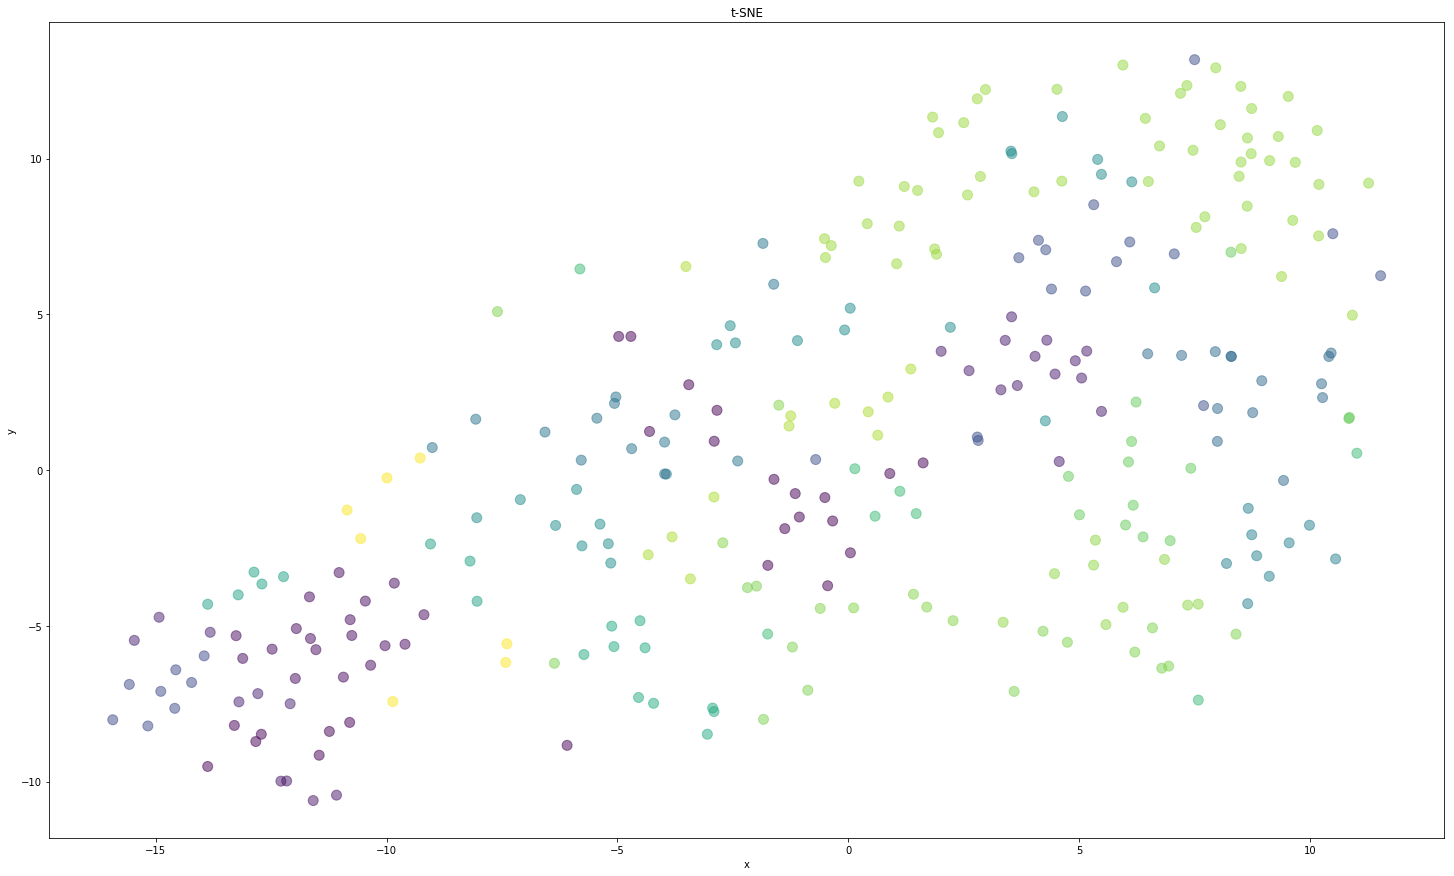

In [246]:
theta = 2 * np.pi * np.random.rand(n)
np.random.shuffle(theta)
colors = [theta[x] for x in kmeans.labels_]

fig, ax = plt.subplots(figsize=(25, 15))
ax.scatter(tsne_results[:, 0], tsne_results[:, 1], alpha=0.5, c=colors, s=[100]*len(tsne_results))
plt.title('t-SNE')
plt.xlabel('x')
plt.ylabel('y')
plt.show()